<a href="https://colab.research.google.com/github/bcamposbernardes-maker/cep/blob/main/sieptrab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== ANOVA para Neighborhood ===


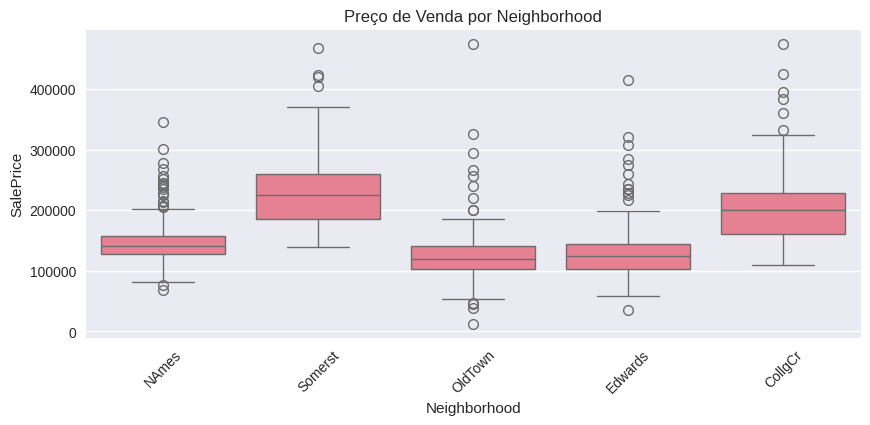

Levene p=0.0000 | ANOVA p=0.0000
✅ Diferenças significativas entre grupos.
⚠️ Heterocedasticidade → aplicando Kruskal-Wallis
Kruskal-Wallis p=0.0000

=== ANOVA para OverallQual ===


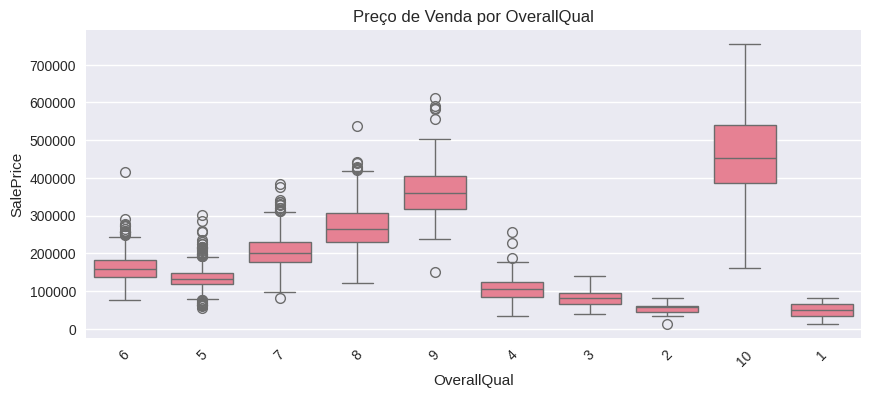

Levene p=0.0000 | ANOVA p=0.0000
✅ Diferenças significativas entre grupos.
⚠️ Heterocedasticidade → aplicando Kruskal-Wallis
Kruskal-Wallis p=0.0000

=== ANOVA para Fireplaces ===


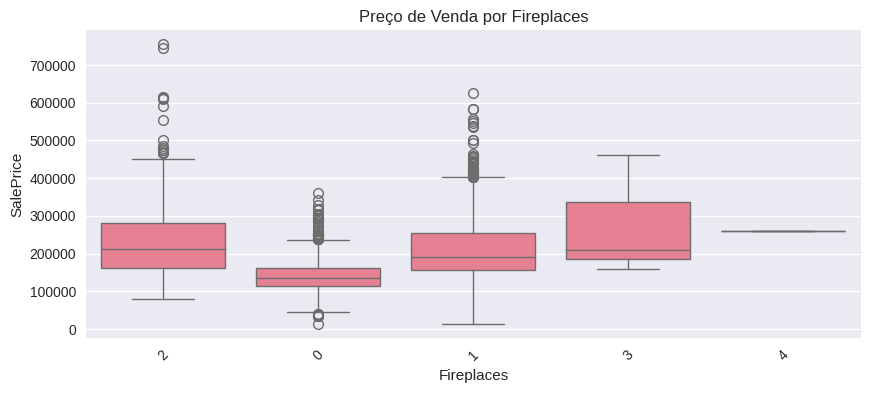

Levene p=0.0000 | ANOVA p=0.0000
✅ Diferenças significativas entre grupos.
⚠️ Heterocedasticidade → aplicando Kruskal-Wallis
Kruskal-Wallis p=0.0000
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2111.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:36:54   Log-Likelihood:                -34993.
No. Observations:                2930   AIC:                         7.000e+04
Df Residuals:                    2924   BIC:                         7.003e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      

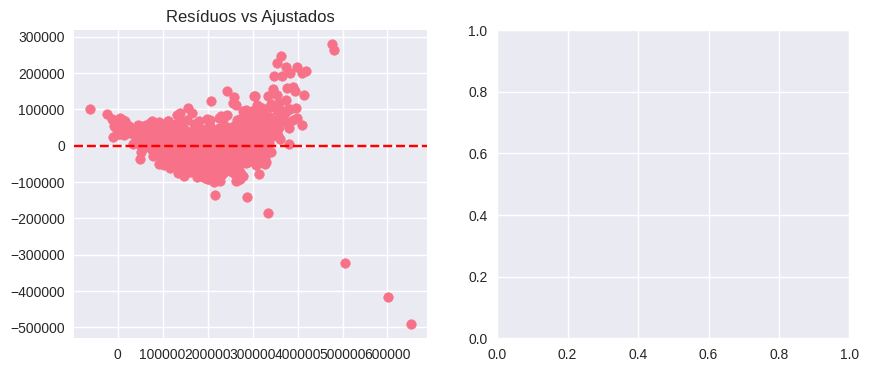

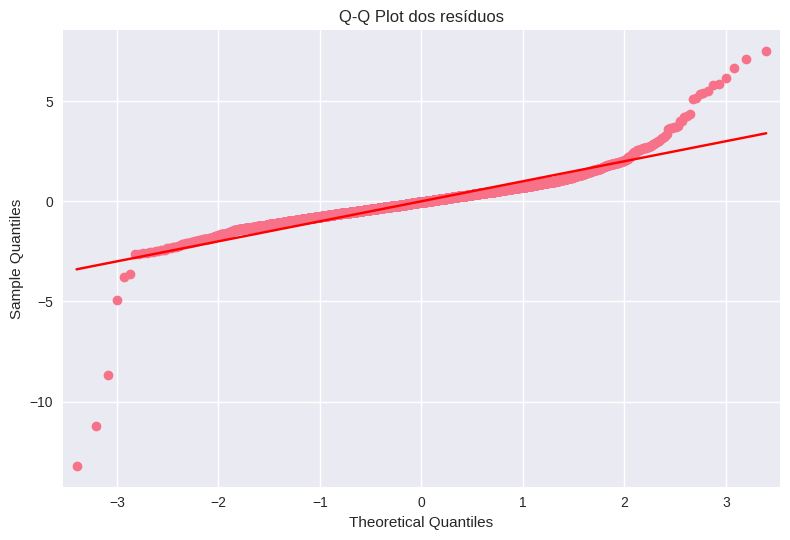

Shapiro p=0.0000 | Breusch-Pagan p=0.0000
                            OLS Regression Results                            
Dep. Variable:          log_SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     2451.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:36:55   Log-Likelihood:                 885.42
No. Observations:                2930   AIC:                            -1759.
Df Residuals:                    2924   BIC:                            -1723.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------


In [ ]:
# -*- coding: utf-8 -*-
"""Tarefa Integrada: Análise de Dados Imobiliários com ANOVA e Regressão Linear"""

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, f_oneway, kruskal
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configurações gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================
# 1. Importação e Preparação
# =============================
df = pd.read_csv("AmesHousing.csv", sep=';')

# Padronizar nomes das colunas (sem espaços)
df.columns = df.columns.str.replace(' ', '')

# Tratar valores ausentes
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

# =============================
# 2. ANÁLISE COM ANOVA
# =============================
cat_vars = ['Neighborhood', 'OverallQual', 'Fireplaces']
target = 'SalePrice'

for var in cat_vars:
    print(f"\n=== ANOVA para {var} ===")

    # Limitar categorias se necessário
    if df[var].nunique() > 10:
        top = df[var].value_counts().head(5).index
        df_temp = df[df[var].isin(top)]
    else:
        df_temp = df.copy()

    # Boxplot
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df_temp[var].astype(str), y=target, data=df_temp)
    plt.title(f'Preço de Venda por {var}')
    plt.xticks(rotation=45)
    plt.show()

    # Agrupar dados
    groups = [df_temp[df_temp[var]==cat][target] for cat in df_temp[var].unique()]

    # Testes estatísticos
    stat_levene, p_levene = levene(*groups)
    f_stat, p_anova = f_oneway(*groups)
    print(f"Levene p={p_levene:.4f} | ANOVA p={p_anova:.4f}")

    if p_anova < 0.05:
        print("✅ Diferenças significativas entre grupos.")
    else:
        print("❌ Sem diferenças significativas.")

    if p_levene < 0.05:
        print("⚠️ Heterocedasticidade → aplicando Kruskal-Wallis")
        stat_kw, p_kw = kruskal(*groups)
        print(f"Kruskal-Wallis p={p_kw:.4f}")

# =============================
# 3. REGRESSÃO LINEAR
# =============================
vars_reg = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'Fireplaces', 'GarageCars']
df_reg = df[vars_reg].dropna()

X = sm.add_constant(df_reg.drop('SalePrice', axis=1))
y = df_reg['SalePrice']

model = sm.OLS(y, X).fit()
print(model.summary())

# Diagnóstico
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', ls='--')
plt.title("Resíduos vs Ajustados")
plt.subplot(1,2,2)
sm.qqplot(model.resid, line='s', fit=True)
plt.title("Q-Q Plot dos resíduos")
plt.tight_layout()
plt.show()

# Testes
shapiro_stat, shapiro_p = shapiro(model.resid)
bp_lm, bp_pval, _, _ = het_breuschpagan(model.resid, model.model.exog)
print(f"Shapiro p={shapiro_p:.4f} | Breusch-Pagan p={bp_pval:.4f}")

# =============================
# 4. MODELO LOG-LOG
# =============================
df_log = df_reg.copy()
for c in ['SalePrice','GrLivArea','TotalBsmtSF']:
    df_log[f'log_{c}'] = np.log(df_log[c] + 1)

X_log = sm.add_constant(df_log[['log_GrLivArea','log_TotalBsmtSF','OverallQual','Fireplaces','GarageCars']])
y_log = df_log['log_SalePrice']

model_log = sm.OLS(y_log, X_log).fit()
print(model_log.summary())

# =============================
# 5. MÉTRICAS DE DESEMPENHO
# =============================
y_pred = model.predict(X)
y_pred_log = np.exp(model_log.predict(X_log))

print("\nDesempenho:")
print(f"Modelo Linear → R²={model.rsquared:.3f}")
print(f"Modelo Log-Log → R²={model_log.rsquared:.3f}")


In [ ]:
print(df.columns.tolist())


['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea

In [ ]:
# Normalizar os nomes das colunas (remove espaços, traços e underscores)
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.replace('_', '')

# Conferir os primeiros nomes de colunas
print("✅ Colunas normalizadas:")
print(df.columns.tolist()[:20])


✅ Colunas normalizadas:
['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond']
